In [2]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

# Beyond Metropolis: a more realistic example

As discussed in the previous notebook, the Metropolis algorithm is the basic building block of MCMC. It is *guaranteed* to converge on the target distribution, but convergence will be *more efficient* if the **jump** (or **proposal**) distribution is similar to the target. This motivates the development of **adaptive** algorithms, where the proposal distribution is "tuned" as the Markov chain progresses.

There are lots of ways of implemeting adaptation (as well as various other innovations for improving the sampling efficiency), but a detailed description of modern MCMC algorithms is beyond the scope of these notes. What's more, if you're a hydrologist or an ecologist (rather than a statistician), you're probably more interested in *applying* MCMC, rather than learning about all the mathematical details. Fortunately, if you understand the principles and motivation behind the Metropolis algorithm (see notebook 4), you should be in a good position to use some more sophisticated MCMC packages without having to worry about the algorithms themselves.

## 1. Useful Python packages

In this notebook, we'll start off by introducing two Python packages that implement a variety of state-of-the-art MCMC algorithms. We'll then illustrate the *entire model development and calibration process* by building a very basic hydrological model from scratch, and then calibrating it using some real data and a very powerful, modern MCMC algorithm.

### 1.1. PyMC3

**[PyMC3]('https://github.com/pymc-devs/pymc3')** is a Python package offering a variety of sophisticated MCMC samplers, including **Hamiltonian Monte Carlo (HMC)** and the **No U-Turn Sampler (NUTS)**. It also provides a very clean syntax for model specification (defining priors, likelihoods etc.), as well as convenience functions for a wide range of distributions. This makes setting up a model and running MCMC very simple: as an illustration, check out the **linear regression** example in the [PyMC3 tutorial]('http://pymc-devs.github.io/pymc3/getting_started/'). This is very similar to the example covered in notebook 4, except there we coded everything from scratch and used only a basic Metropolis algorithm. With PyMC3, the number of lines of code is dramatically reduced and we have the added advantage of being able to switch easily between several modern samplers.

However, a key property of the HMC and NUTS algorithms is they use the **gradient** of the target function to help tune the proposal distribution. This gives excellent performance for high-dimensional problems, but requires the target function to be **differentiable**. Unfortunately, as we have already seen in notebook 3, for complex environmental models the likelihood function is often not well-behaved, so the posterior distribution is not differentiable and many of the advantages of the HMC and NUTS algorithms are lost.

### 1.2. emcee

**[emcee]('http://dan.iel.fm/emcee/current/')** is Python package which implements an **affine invariant MCMC ensemble sampler** (a more detailed description of the algorithm from the package authors is [here]('http://arxiv.org/abs/1202.3665')). This sampler uses **multiple chains** together with some clever mathematical "tricks" to tune the proposal distribution *without* requiring any gradient information. This makes it ideal for the kinds of complex likelihoods commonly encountered in environmental modelling. Furthermore, although in high-dimensional parameter spaces the HMC or NUTS algorithms *may* be more efficient, the multiple chains used by emcee are easy to parallelise (see notebook 4), which offers a significant performance advantage.

The downside of emcee is that, unlike PyMC3, there are no easy ways to specify your model: you have to write Python functions from scratch to represent your priors, likelihood and posterior. For simple models, this is not a major limitation, but for more complex likelihoods (e.g. more sophisticated error structures) the process can become time consuming.

[It is possible]('http://twiecki.github.io/blog/2013/09/23/emcee-pymc/') that the emcee algorithm will eventually be integrated into PyMC3, but in the meantime I recommend investigating both packages as they're useful in different situations. 

In the example below we'll use emcee.

## 2. A hydrological example

We're going to illustrate everything we've covered so far using a highly simpified but slightly more realisitc example. We'll formulate a very basic hydrological model to simulate flows in a small Scottish catchment. The model will be too simplistic for any real-world application, but I hope it will provide a useful illustration of the modelling process. We'll then use emcee to calibrate the model and see what we can learn about the model parameters *given some real data*.

### 2.1. The study catchment

We're going to use some data from the **Tarland catchment** in Aberdeenshire, Scotland. Flow data are available from 2001 to 2010, together with rainfall and potential evapotranspiration (PET) datasets for the same period that we'll use to drive our model. The catchment has an area of $51.7\,km^2$ and we'll be using flow data from the gauging station at **Coull**.

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeWXluaE9wMGtnMUk" alt="Tarland catchment map" height="700" width=700> 

It is important to stress that *all* of these datasets are subject to **error**. For example:

  1. The rainfall data come from spatially interpolated rain gauge measurements. Rain gauges are notoriously inaccurate (especially in Scotland where it's often raining horizontally) and the spatial interpolation process adds further uncertainty <br><br>
  
  2. PET has been estimated using the **[FAO56 modified Penman-Monteith method]('http://www.fao.org/docrep/x0490e/x0490e00.htm')**. This is a whole model in itself, incorporating data on cloud cover, solar radiation, humidity, wind speed, temperature etc., all of which are imperfectly measured. The method (as presented here) also assumes that the land cover is uniform grass of an even height, which is not the case in the Tarland catchment <br><br>
  
  3. The flow data are based on an empirically derived **[stage-discharge relationship]('http://water.usgs.gov/edu/streamflow3.html')** which is subject to considerable uncertainty due to changing riverbed sediments and limited gauging data, especially for high flows
  
Understanding the limitations of the data is important and in a more comprehensive analysis we might attempt to incorporate uncertainty about our input and calibration data into our likelihood function. Even if we do not do this, we should certainly spend some time **quality checking** the data and perhaps **cleaning or removing points that are obviously spurious**. For the simple example presented here, we will *ignore all these issues* and instead focus only on the **parameter-related uncertainty** in our model. This is an important omission, but I want to keep this example as simple as possible.

The precipitation and flow data have a **daily** time step, whereas the PET data are **monthly**. For now, we'll simply assume that the monthly PET totals are distributed evenly over each day of the month.

Note that throughout this entire analysis, all water **volumes** will be expressed in **millimetres**. This is not a mistake - we're simply performing all the calculations **per unit area** so that we can visualise what's going on in terms of a 2D conceptualisation (see below). In reality, the Tarland catchment has an area of $51.7 \, km^2$, so a rainfall input of 1 mm equates to an actual water volume of $1 \times 10^{-3} * 51.7 \times 10^6 = 51.7 \times 10^3 \, m^3$. 

            Q_Cumecs  Rainfall_mm  PET_mm
Date                                     
2000-01-01    0.7764         0.10    0.72
2000-01-02    0.7808         1.00    0.72
2000-01-03    0.7302         1.10    0.72
2000-01-04    0.6917         1.38    0.72
2000-01-05    0.6984         3.62    0.72


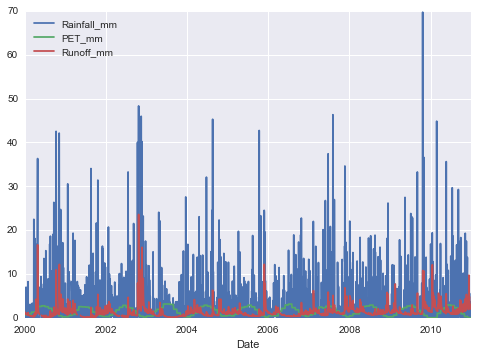

In [3]:
# Download Tarland data into a Pandas dataframe
data_url = r'https://drive.google.com/uc?export=&id=0BximeC_RweaecHNIZF9GMHkwaWc'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)
print met_df.head()

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']
met_df.plot()

In [4]:
# Calculate annual averages for rainfall, PET and runoff
ann_df = met_df.resample('A', how='sum')
print ann_df.mean()

Rainfall_mm    965.661818
PET_mm         529.885455
Runoff_mm      452.875483
dtype: float64


Broadly speaking, these annual averages are about what would be expected for a catchment like the Tarland in Eastern Scotland, with the exception that the PET losses are rather too high. This is because the FAO56 PET calculation (linked above) assumes the land cover is grass with no moisture stress, whereas the actual land cover in the Tarland is mixture of agriculture, forestry, rough grazing and upland vegetation. For comparison, according to the **[UK Hydrometric Register]('http://nora.nerc.ac.uk/3093/1/HydrometricRegister_Final_WithCovers.pdf')**, the Girnock Burn at Littlemill (a little to the southwest of the Tarland) has a long term average annual rainfall of $998 \, mm$ and a mean annual runoff of $554 \, mm$. This means the **actual evapotranspiration (AET)** (plus other losses) accounts for around $454 \, mm$ per year. We're not going to worry about this too much, but we will build a simple *correction factor* into our model to modify the unreasonably high rate of PET.

### 2.2. A conceptual hydrological model

We are going to represent the entire Tarland catchment as **two connected "buckets"**, one representing the **soil water** reservoir and the other representing the **groundwater**. This approach is very common in hydrology, except most practically useful models break the system down into more buckets. For example, some models use different buckets for different combinations of land cover and soil type (often called "**hydrological response units**"); others divide the subsurface into more than two reservoirs, by having e.g. separate "buckets" for shallow versus deep groundwater, and perhaps the same for soil water too. There are many variations on this theme, and once you have lots of buckets there are numerous ways of linking them together, which leads to consideration of e.g. water travel times along different river reaches and between different water stores. 

All of this adds to the complexity of the model and can quickly lead to **over-parameterisation** (as described in notebook 2). We're going to *ignore all of these complexities as well* and just consider two simple buckets. With such a basic setup we certainly can't be accused of over-parameterisation, but equally it's unlikely that this model will be very informative in terms of understanding the hydrology of the Tarland catchment.

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeczNHQy1oTzZtYmc" alt="Two bucket model" height="400" width=400> 

As part of our conceptualisation, we will assume that the **hydrologically effective rainfall**, $H$, entering the soil bucket at each time step is equal to the precipitation, $P$, minus the **actual** evapotranspiration. We know from above that the AET is likely to be less than the PET values in our input data, so we'll introduce a correction factor, $\alpha$. 

Denoting the input PET values as $E$, we will assume that   

$$H = P - \alpha E$$

The flow of water out of the soil reservoir, $S$, is assumed to be proportional to the volume of water currently stored in the bucket, $V_s$. The constant of proportionality in this relationship is $\frac{1}{\tau_s}$, where $\tau_s$ is known as the **soil water residence time**. This is the average length of time (in days) that a molecule of water spends in the soil water reservoir between flowing in and flowing out. $\tau_g$ is the equivalent for the groundwater store.

$$S = \frac{1}{\tau_s} V_s \qquad and \qquad G = \frac{1}{\tau_g} V_g$$

It's worth mentioning here that these assumptions have at least some physical basis: the equations represent the behaviour of a bucket with a hole in the bottom **filled with some porous material** (e.g. soil or sediment) such that the flow of water through the hole is **laminar**. (Note that without the porous material the equations would be different.)

A fraction, $\beta$, of the water draining from the soil reservoir moves downwards into the groundwater. $\beta$ is sometimes referred to as the **Base Flow Index** and it can be estimated in a variety fo ways. The remainder of the soil drainage, $(1 - \beta S)$, is assumed to travel **immediately** to the stream along fast, shallow flow pathways. 

We want to use the model to predict he total runoff to the stream, $R$, at each time step

$$R = (1 - \beta S) + G$$

Although this is a very simple model, we already have a lot of choices regarding what to include in our calibration procedure. We have decided above not to explicitly consider errors in the input time series, $P$ and $E$, or in the observed flow data, $R_{obs}$. The model also has four parameters: $\alpha$, $\beta$, $\tau_s$ and $\tau_g$. Previous work has indicated that $\beta$, the base flow index for Tarland, is somewhere in the region of $0.6$. There is likely large uncertainty associated with this value, but to keep things simple we will fix $\beta$ in this example and calibrate only the remaining three parameters.

A final decision that we must make concerns the **initial conditions** for our model. For example, what is a reasonable starting water level in the soil and groundwater reservoirs? To begin with, we will assume that both reservoirs are initially empty, but we may return to this later.

based on the considerations above, for the soil box we have

$$\frac{dV_s}{dt} = H - S \qquad and \qquad V_s = ST_s \qquad therefore \qquad \frac{dS}{dt} = \frac{H - S}{T_s}$$

and similarly

$$\frac{dV_g}{dt} = \beta S - G \qquad and \qquad V_g = GT_g \qquad therefore \qquad \frac{dG}{dt} = \frac{\beta S - G}{T_g}$$

We can integrate these equations to obtain expressions describing how $S$ and $G$ vary with time. These expressions enable us to calculate the flow rate from the soil and groundwater reservoirs at point. Furthermore, if we integrate the equations *again* we can calculate the **volume of water** draining from the two boxes within any interval of interest (this is because the area under the flow rate curve is equal to the volume).

To represent all this, we can write down a system of four **coupled, first-order Ordinary Differential Equations (ODEs)**

$$\frac{dS}{dt} = \frac{H - S}{T_s}$$

$$\frac{dG}{dt} = \frac{\beta S - G}{T_g}$$

$$\frac{dD_s}{dt} = (1 - \beta) S$$

$$\frac{dD_g}{dt} = G$$

where $D_s$ is the flow volume from the soil to the stream and $D_g$ is the flow volume from the groundwater to the stream.

These equations actually have simple **analytical** solutions, but in general our models will be more complex and the system of ODEs may be impossible to solve exactly. For this reason we will use the `odeint` **numerical solver** from SciPy which, although not necessary here, is likely to be more useful in real applications. 

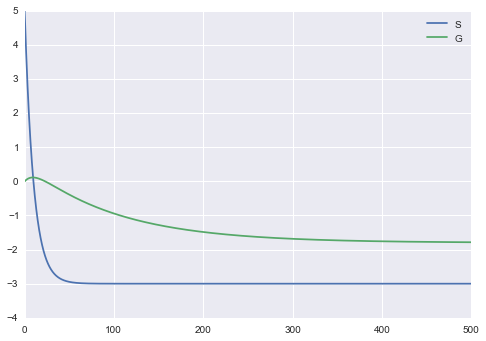

In [55]:
import PyDSTool as dst
from PyDSTool import args

# #############################################################################
# Define constants
H = -3.       # HER (mm/day). Assume constant for now
beta = 0.6   # BFI (dimensionless)
T_s = 10     # Soil residence time (days). Needs calibrating; assume constant for now
T_g = 100    # Groundwater residence time (days). Needs calibrating; assume constant for now

# Define initial conditions (all boxes empty)
S0 = 5.     # Soil outflow (mm/day)
G0 = 0.     # Groundwater outflow (mm/day)   
Ds0 = 0.    # Soil drainage volume (mm)
Dg0 = 0.    # Groundwater drainage volume (mm)

# Number of days to simulate
days = 500
# #############################################################################

# Build model for PyDSTool
# Define parameters
par_dict = {'H':H, 'beta':beta, 'T_s':10, 'T_g':100}

# Define initial conditions
ic_dict = {'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0}

# Define ODEs
dS_dt = '(H - S)/T_s'       # Soil outflow rate (mm/day)
dG_dt = '(beta*S - G)/T_g'  # Groundwater outflow rate (mm/day)
dDs_dt = '(1 - beta)*S'     # Accumulated soil drainage to stream (mm)
dDg_dt = 'G'                # Accumulated groundwater drainage to stream (mm)

# Define variables
var_dict = {'S':dS_dt, 'G':dG_dt, 'Ds':dDs_dt, 'Dg':dDg_dt}

# Define an "event" for terminating the integration if soil store dries out
event_S_0 = dst.makeZeroCrossEvent('S', 0,
                                   {'name': 'soil_dry',
                                    'eventtol': 1e-6,
                                    'term': True,
                                    'active': True},
                                   varnames=['S'])

# Build model
DSargs = args(name='two_bucket_model')
#DSargs.events = [event_S_0]       
DSargs.xdomain = {'S':[0, dst.Inf], 'G':[0, dst.Inf], 'Ds':[0, dst.Inf], 'Dg':[0, dst.Inf]} 
DSargs.ics = ic_dict               
DSargs.pars = par_dict             
DSargs.tdata = [0, days]           
DSargs.varspecs = var_dict

# Solve model
DS = dst.Generator.Vode_ODEsystem(DSargs)

# Extract results
traj = DS.compute('model')
pts = traj.sample()

# Add to df
df = pd.DataFrame(data={'S':pts['S'],
                        'G':pts['G'],
                        'Ds':pts['Ds'],
                        'Dg':pts['Dg']},
                  index=pts['t'])

df[['S', 'G']].plot()

The plot above shows how the flow rate from the soil and groundwater boxes changes over time, assuming both reservoirs start off empty and receive a steady, constant inflow, $H$, of $5\,mm/day$. The results are intuitively sensible: the outflow, $S$, from the soil box is initially zero, so the flow in exceeds the flow out and the reservoir begins to fill. As it fills, the outflow increases in proportion to the water level (see equations above). As time passes, the outflow rate from the soil asymptotically approaches the inflow rate of $5\,mm/day$, and the water level in the soil reservoir stabilises.

Exactly the same is true for the groudnwater reservoir, except the input here is $\beta S$, so the groundwater outflow rate asymptotically approaches $0.6*5 = 3 \; mm/day$. Also, because the residence time of the groundwater is longer than for the soil reservoir, the groundwater outflow responds more slowly.

The code above assume a constant input of water, $H$, to the soil box. In reality, our model will be driven by a **discrete** time series of values of $H$, calculated from our input data as $H = R - \alpha E$ (see above). The discrete nature of this data can cause problems for `odeint`, so to be safe we will solve the ODEs separately for **each time step** in the input data. essentially, we will use the equations above to describe how the system evolves *within* each time step. From our initial conditions, we will start by solving the equations using $H = H_1$ to calculate the state of the system at the end of the first time step. We will then use these values as the initial conditions for second time step with $H = H_2$, and so on.   

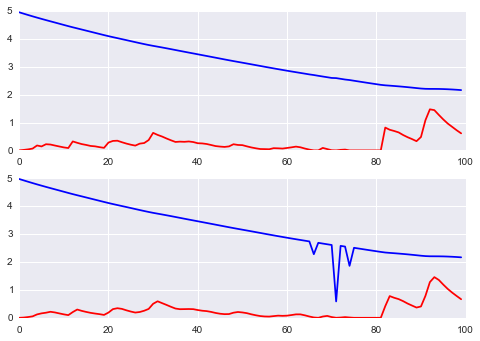

In [44]:
# Define constants
alpha = 0.75 # ET correction factor (dimensionless). Needs calibrating; assume constant for now
beta = 0.6   # BFI (dimensionless)
T_s = 10.     # Soil residence time (days). Needs calibrating; assume constant for now
T_g = 100.    # Groundwater residence time (days). Needs calibrating; assume constant for now

# Define initial conditions (all boxes empty)
S0 = 0.     # Soil outflow (mm/day)
G0 = 5.     # Groundwater outflow (mm/day)   
Ds0 = 0.    # Soil drainage volume (mm)
Dg0 = 0.    # Groundwater drainage volume (mm)

# Calculate the time series of H values
met_df['HER_mm'] = met_df['Rainfall_mm'] - alpha*met_df['PET_mm']

# Update the model (defined above) to reflect new requirements
DS.set(tdata=[0, 1],
       pars={'beta':beta, 'T_s':T_s, 'T_g':T_g},
       ics={'S':S0, 'G':G0, 'Ds':Ds0, 'Dg':Dg0})

# List to store output
out_list = []

# Loop over discrete H time series
for step in range(100): #range(len(met_df)):
    # Get H for this step
    H = float(met_df['HER_mm'].ix[step])

    # Set H in model
    DS.set(pars={'H':H})
    
    # Extract results
    traj = DS.compute('model')
    pts = traj.sample()[-1] # Get only the last values (for t=1)

    # The algorithm tracks "zero crossing events" to within a specified tolerance
    # (1E-6 from above). When an event is triggered, S can still end up being
    # very small and negative (e.g. -1E-7). This causes problems as the negative
    # value becomes the initial condition for the next step. The algorithm can 
    # then evolve in a negative direction, and will only trigger a new event when 
    # it crosses back to being positive (i.e the wrong way!). To avoid this, we 
    # need to set any negative values of S back to zero before the next step.
    # When starting from a dry store, it is also possible to get tiny negative 
    # values for other variable. Set these to zero too
    for key in pts.keys():
        if pts[key]<0:
            pts[key]=0
        
    # Append results
    out_list.append([pts['S'], pts['G'], pts['Ds'], pts['Dg']])
    
    # Update initial condition for next step
    DS.set(ics={'S':pts['S'],
                'G':pts['G']})
    
data_df = pd.DataFrame(data=np.vstack(out_list), columns=['S', 'G', 'Ds', 'Dg'])

fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(data_df.index, data_df['S']*(1-beta), 'r-')
axes[0].plot(data_df.index, data_df['G'], 'b-')

axes[1].plot(data_df.index, data_df['Ds'], 'r-')
axes[1].plot(data_df.index, data_df['Dg'], 'b-')

plt.show()

Need to check the strange results here.

What are spikes on plot above? Think this is because when the soil dries out the integrator terminates, so the GW drainage gets interupted too. This is not what we want to happen.

Are the equations for drainiage volume necessary? I think they're correct, but with a daily time step the plots are almost the same as for the outflow.